In [0]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# ??? Perform min_max_scaler to YEAR, TOTAL_HRS,MONTH
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

import matplotlib.pyplot as plt


In [0]:
initial_data = pd.read_excel('./OUTPUT_WBI_exposer_cyclones_v11.xlsx')

In [86]:
initial_data.shape

(1019, 48)

In [0]:
initial_data = initial_data.drop_duplicates(subset=['NAME','ISO','YEAR'], keep="last")

In [88]:
initial_data.shape

(998, 48)

In [89]:
initial_data.head()

,SID,NAME,BASIN,SUB BASIN,ISO,YEAR,MONTH_START,MONTH_END,DATE_START,DATE_END,DATE_LAND_START,DATE_LAND_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,COORDS,COORDS_MAX_WINDS,COORDS_MIN_DIST2LAND,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,34KN_POP,64KN_POP,96KN_POP,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,POP_MAX_34,POP_MAX_50,POP_MAX_64,64KN_ASSETS,34KN_ASSETS,96KN_ASSETS,POP_DEN_SQ_KM,RURAL_POP(%),POP_TOTAL,RURAL_POP,HDI,TOTAL_DAMAGE_(000$),TOTAL_DEATHS,TOTAL_AFFECTED
0,1949163N07145,DELLA,WP,WP,JPN,1949,6,6,1949-06-19 09:00:00,1949-06-24 06:00:00,1949-06-20 15:00:00,1949-06-23 03:00:00,117.0,60.0,TS,Cat 4,116.0,952,0,33.0,3,0,99.82,"[(21.5, 125.424), (22.2, 125.8), (22.9089, 126...","[(27.6584, 128.82), (28.9141, 129.572999999999...","[(31.9866, 130.683), (33.5183, 130.97299999999...",3889.480640,3632.626180,NaN,NaN,NaN,1.198300e+07,5.803981e+06,3.320907e+06,16431894.0,7958809.0,4553851.00,NaN,NaN,NaN,195.0,77.20,81700000,63072400.0,0.816,NaN,419.0,194046
1,1950241N23140,JANE,WP,WP,JPN,1950,8,9,1950-08-30 03:00:00,1950-09-05 00:00:00,1950-09-03 03:00:00,1950-09-04 00:00:00,141.0,21.0,ET,Cat 4,116.0,940,0,31.0,3,1,99.82,"[(23.8845, 139.74), (23.9335, 139.639), (23.98...","[(28.7509, 133.748), (29.1201, 133.762), (29.6...","[(34.9374, 135.476), (36.1016, 136.095), (37.2...",3596.090691,2787.480021,NaN,NaN,NaN,3.160822e+07,1.559196e+07,1.018936e+07,43343320.0,21380746.0,13972339.00,NaN,NaN,NaN,227.0,47.00,82800000,38916000.0,0.816,NaN,509.0,642117
2,1951224N12316,CHARLIE,NAm,CS,JAM,1951,8,8,1951-08-17 21:00:00,1951-08-18 12:00:00,1951-08-18 03:00:00,1951-08-18 06:00:00,15.0,3.0,TS,Cat 3,110.0,0,0,17.0,3,3,132.40,"[(17.3398, -75.4138), (17.6, -76.2), (17.9, -7...","[(17.6, -76.2), (17.9, -76.9)]","[(17.9, -76.9), (18.1, -77.8)]",438.214691,435.729082,2788659.0,2788659.0,2552903.0,1.689243e+06,1.687083e+06,1.195052e+06,2753687.5,2750167.0,1948090.75,2.148198e+10,2.148198e+10,1.948346e+10,133.0,66.23,1440000,953712.0,0.668,56000.0,154.0,20200
3,1951337N09150,AMY,WP,WP,PHL,1951,12,12,1951-12-07 09:00:00,1951-12-17 00:00:00,1951-12-09 12:00:00,1951-12-11 00:00:00,231.0,36.0,TS,Cat 4,120.0,924,0,11.0,4,2,119.20,"[(12.0725, 130.967), (12.1333, 130.517), (12.1...","[(11.7833, 127.9)]","[(10.7333, 124.8), (10.534, 123.174), (10.6833...",2238.058669,1905.587795,20464826.0,12675908.0,5618193.0,4.760039e+06,3.006670e+06,1.114774e+06,14131997.0,8926450.0,3309632.25,1.131050e+11,1.880280e+11,4.897333e+10,64.5,75.35,19200000,14467200.0,0.590,NaN,569.0,60000
4,1952180N05144,EMMA,WP,WP,PHL,1952,7,7,1952-07-01 06:00:00,1952-07-04 18:00:00,1952-07-02 12:00:00,1952-07-02 21:00:00,84.0,9.0,TS,Cat 3,110.0,968,0,15.0,3,1,110691.00,"[(9.33776, 130.185), (9.38633, 129.61), (9.45,...","[(9.45, 129.017), (9.50407, 128.407), (9.56613...","[(10.4667, 123.867), (10.6492, 123.239), (10.8...",1876.186790,1797.712213,NaN,NaN,NaN,5.130796e+06,2.789486e+06,1.988524e+06,15232730.0,8281656.5,5903694.00,NaN,NaN,NaN,66.9,72.41,19900000,14409590.0,0.590,NaN,19.0,103


In [0]:
def split_to_list(str_):
    return str_[2:-2].split("), (")
    
def list_to_lat_lon(str_list):
    lat=[]
    lon=[]
    for i in str_list:
        lat.append(i.split(", ")[0])
        lon.append(i.split(", ")[1])
    return lat, lon

def dist_(x1,y1,x2,y2):
    try:
        x = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    except:
        x = 0
    return x
        
def tot_dist(lat, lon):
    dist_lst=[]
    for i in range(0, len(lat)):
        lat[i] = float(lat[i]) 
    for i in range(0, len(lon)):
        lon[i] = float(lon[i]) 
  
    for i, (a, b) in enumerate(zip(lat, lon)):
        
        try:
            
            x1 = a
            x2 = lat[i+1]
            y1 = b
            y2 = lon[i+1]
         
            dist_lst.append(dist_(float(x1),float(y1),float(x2),float(y2)))
            
        except:
            pass

    try:
        avg_dist = sum(dist_lst)/len(dist_lst)
    except:
        avg_dist = 0
    return sum(dist_lst),  avg_dist
        
initial_data['dist'] = initial_data['COORDS'].apply(lambda x: tot_dist(list_to_lat_lon(split_to_list(x))[0], list_to_lat_lon(split_to_list(x))[1])[0] )
initial_data['dist_3'] = initial_data['COORDS'].apply(lambda x: tot_dist(list_to_lat_lon(split_to_list(x))[0], list_to_lat_lon(split_to_list(x))[1])[1] )

In [0]:
initial_data['COORDS_both']=initial_data['COORDS'].str[2:18]
initial_data['COORDS_1'] = initial_data['COORDS_both'].str.split(", ", n = 1, expand = True)[0]
initial_data['COORDS_2'] = initial_data['COORDS_both'].str.split(", ",  expand = True)[1]
initial_data['COORDS_2'] = initial_data['COORDS_2'].str.split(")",  expand = True)[0]
initial_data['COORDS_1'] = initial_data['COORDS_1'].astype(float)
initial_data['COORDS_2'] = initial_data['COORDS_2'].astype(float)

Trying to estimate the Affected population alone, So removing some features

In [92]:
initial_data.columns

Index(['SID', 'NAME', 'BASIN', 'SUB BASIN', 'ISO', 'YEAR', 'MONTH_START',
       'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START',
       'DATE_LAND_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
       'COORDS', 'COORDS_MAX_WINDS', 'COORDS_MIN_DIST2LAND', 'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP', '96KN_POP',
       'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ', 'POP_MAX_34',
       'POP_MAX_50', 'POP_MAX_64', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
       'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'POP_TOTAL', 'RURAL_POP', 'HDI',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'TOTAL_AFFECTED', 'dist',
       'dist_3', 'COORDS_both', 'COORDS_1', 'COORDS_2'],
      dtype='object')

In [0]:
initial_data['POP_MAX_50_ADJ'] = initial_data['POP_MAX_50_ADJ']-initial_data['POP_MAX_34_ADJ']
initial_data['POP_MAX_50'] = initial_data['POP_MAX_50']-initial_data['POP_MAX_34']
initial_data['POP_MAX_34_ADJ'] = initial_data['POP_MAX_34_ADJ']-initial_data['POP_MAX_50_ADJ']
initial_data['POP_MAX_34'] = initial_data['POP_MAX_34']-initial_data['POP_MAX_50']

In [94]:
initial_data['POP_MAX_50'][initial_data['POP_MAX_50'] < 0] = 0
initial_data['POP_MAX_50_ADJ'][initial_data['POP_MAX_50_ADJ'] < 0] = 0
initial_data['POP_MAX_64'][initial_data['POP_MAX_64'] < 0] = 0
initial_data['POP_MAX_64_ADJ'][initial_data['POP_MAX_64_ADJ'] < 0] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [0]:
req_columns = ['YEAR','BASIN','SUB BASIN','NATURE','TOTAL_HRS','USA_SSHS','ISO_TIME',
              'WIND_CAL_MIN','WIND_CAL_MAX','WIND_CALC_MEAN','PRES_CAL_MIN','PRES_CAL_MAX',
              'PRES_CALC_MEAN','STORM_SPD_MIN','STORM_SPD_MAX','STORM_SPD_MEAN','STORM_DR_MIN',
              'STORM_SPD_MAX','STORM_DR_MEAN','V_LAND_KN','CPI','TOTAL_DAMAGE_(000$)',
               'Population density (people per sq. km of land area)',
              'Rural population (% of total population)','TOTAL_AFFECTED']
req_columns = ['YEAR','BASIN','SUB BASIN','NATURE','TOTAL_HRS','USA_SSHS','ISO_TIME',
              'WIND_CAL_MIN','WIND_CAL_MAX','WIND_CALC_MEAN','PRES_CAL_MIN','PRES_CAL_MAX',
              'PRES_CALC_MEAN','STORM_SPD_MIN','STORM_SPD_MAX','STORM_SPD_MEAN','STORM_DR_MIN',
              'STORM_SPD_MAX','STORM_DR_MEAN','V_LAND_KN',
               'Population density (people per sq. km of land area)',
              'Rural population (% of total population)','TOTAL_AFFECTED']
req_columns = ['BASIN', 'SUB BASIN', 'COORDS_1', 'COORDS_2', 
       'NATURE', 'ISO_TIME',  'DAY_HRS', 'NIGHT_HRS',
       'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN',
       'STORM_DR_MEAN', 'V_LAND_KN', 'month', #'CPI',
      # 'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 
               #'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 
               #'GDP growth (annual %)',
      # 'GDP per capita (constant 2010 US$)', 
                          #'Net flows from UN agencies US$',
      # 'Life expectancy at birth, total (years)',
       #'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       #'Adjusted savings: education expenditure (% of GNI)',
      # 'Rural population (% of total population)', 
                          'Income_level_Final', 'dist', 'dist_3',
     
       'pop_max_34_adj',
       'pop_max_64_adj', 'TOTAL_AFFECTED']
req_columns = ['BASIN', 'SUB BASIN', 'ISO', 'YEAR', 'MONTH_START',
       #'MONTH_END', droppping high correlation with with month start
       # 'DATE_START', 'DATE_END', 'DATE_LAND_START',
       'DATE_LAND_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED',
        #'MAX_USA_SSHS', 
       #'MAX_USA_SSHS_INLAND', 
       #'V_LAND_KN',
       'COORDS', 'COORDS_MAX_WINDS', 'COORDS_MIN_DIST2LAND', #'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', 
       #ffejfkukuhftvnruncnvvegfjhhvdfjd'34KN_POP', '64KN_POP', '96KN_POP',
       'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ', 'POP_MAX_34',
       'POP_MAX_50', 'POP_MAX_64',
       # '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
       'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'POP_TOTAL', 'RURAL_POP', 
       'HDI',
       #'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 
       'TOTAL_AFFECTED', 
       #'dist',
       # 'COORDS_both',
         'COORDS_1', 'COORDS_2']

In [96]:
plt.figure(figsize=(5,5))

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [0]:
corrMatrix=initial_data[ ['BASIN', 'SUB BASIN', 'ISO', 'YEAR', 'MONTH_START',
       'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START',
       'DATE_LAND_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', #'V_LAND_KN',
       'COORDS', 'COORDS_MAX_WINDS', 'COORDS_MIN_DIST2LAND', #'DISTANCE_TRACK',
       'DISTANCE_TRACK_VINCENTY', #'34KN_POP', '64KN_POP', '96KN_POP',
       'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ', 'POP_MAX_34',
       'POP_MAX_50', 'POP_MAX_64', #'64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
       'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'POP_TOTAL', 'RURAL_POP', 'HDI',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'TOTAL_AFFECTED', #'dist',
        'COORDS_both', 'COORDS_1', 'COORDS_2']]

(27.5, -0.5)

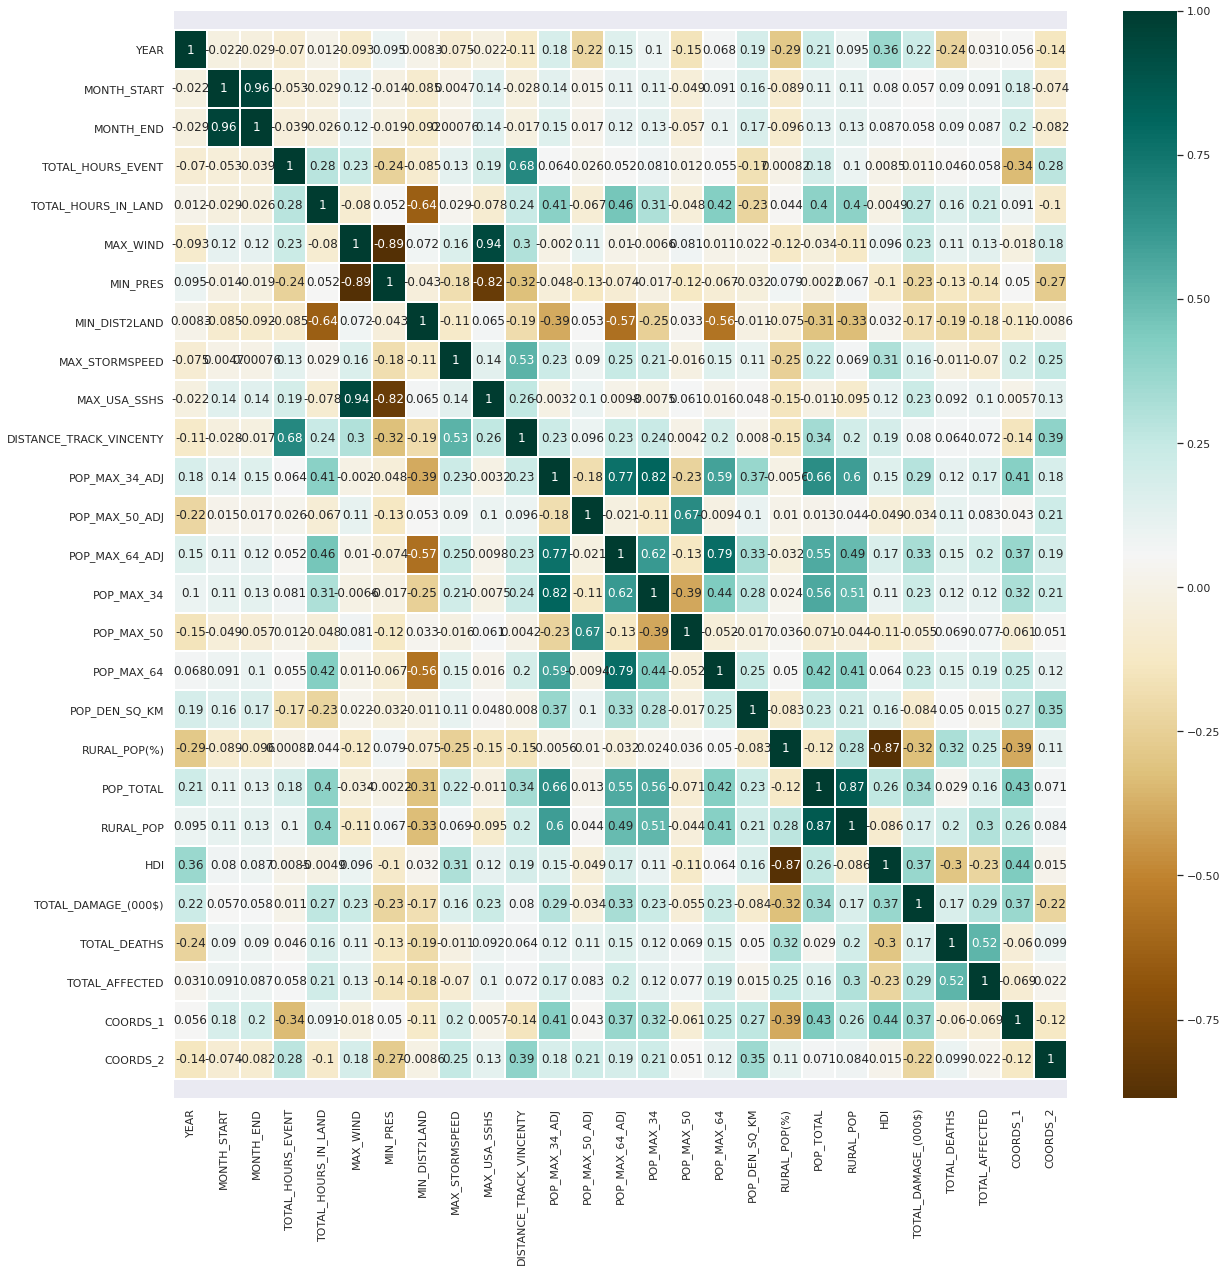

In [98]:
df_num = corrMatrix[corrMatrix.columns.unique()]
corr_num = df_num.corr(method = "spearman")
fig, ax = plt.subplots(figsize=(20,20))
ax = plt.subplot(111)
sns.set(font_scale=1)
sns.heatmap(corr_num, annot=True,  linewidth=1, cmap="BrBG", ax=ax)
bottom, top = ax.get_ylim()             # this fixes a bug where first and last columns were not visualized correctly
ax.set_ylim(bottom + 0.5, top - 0.5)

In [99]:
corrMatrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 1018
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   BASIN                    998 non-null    object        
 1   SUB BASIN                998 non-null    object        
 2   ISO                      998 non-null    object        
 3   YEAR                     998 non-null    int64         
 4   MONTH_START              998 non-null    int64         
 5   MONTH_END                998 non-null    int64         
 6   DATE_START               998 non-null    datetime64[ns]
 7   DATE_END                 998 non-null    datetime64[ns]
 8   DATE_LAND_START          998 non-null    object        
 9   DATE_LAND_END            998 non-null    object        
 10  TOTAL_HOURS_EVENT        998 non-null    float64       
 11  TOTAL_HOURS_IN_LAND      998 non-null    float64       
 12  NATURE                   998 non-nu

OUTLIERS 

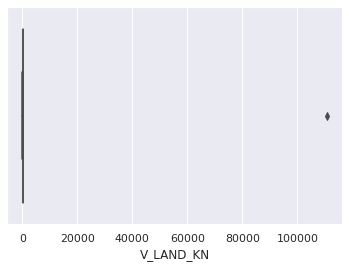

In [100]:
sns.boxplot(x=initial_data['V_LAND_KN']) 

In [101]:
initial_data[initial_data['V_LAND_KN']>60000]

,SID,NAME,BASIN,SUB BASIN,ISO,YEAR,MONTH_START,MONTH_END,DATE_START,DATE_END,DATE_LAND_START,DATE_LAND_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,COORDS,COORDS_MAX_WINDS,COORDS_MIN_DIST2LAND,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,34KN_POP,64KN_POP,96KN_POP,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,POP_MAX_34,POP_MAX_50,POP_MAX_64,64KN_ASSETS,34KN_ASSETS,96KN_ASSETS,POP_DEN_SQ_KM,RURAL_POP(%),POP_TOTAL,RURAL_POP,HDI,TOTAL_DAMAGE_(000$),TOTAL_DEATHS,TOTAL_AFFECTED,dist,dist_3,COORDS_both,COORDS_1,COORDS_2
4,1952180N05144,EMMA,WP,WP,PHL,1952,7,7,1952-07-01 06:00:00,1952-07-04 18:00:00,1952-07-02 12:00:00,1952-07-02 21:00:00,84.0,9.0,TS,Cat 3,110.0,968,0,15.0,3,1,110691.0,"[(9.33776, 130.185), (9.38633, 129.61), (9.45,...","[(9.45, 129.017), (9.50407, 128.407), (9.56613...","[(10.4667, 123.867), (10.6492, 123.239), (10.8...",1876.18679,1797.712213,NaN,NaN,NaN,7.472105e+06,0.0,1.988524e+06,22183803.5,0.0,5903694.0,NaN,NaN,NaN,66.9,72.41,19900000,14409590.0,0.59,NaN,19.0,103,17.134578,0.611949,"9.33776, 130.185",9.33776,130.185


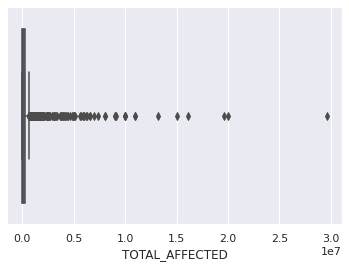

In [102]:
sns.boxplot(x=initial_data['TOTAL_AFFECTED'])

In [103]:
initial_data[initial_data['TOTAL_AFFECTED']>9990000]

,SID,NAME,BASIN,SUB BASIN,ISO,YEAR,MONTH_START,MONTH_END,DATE_START,DATE_END,DATE_LAND_START,DATE_LAND_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,COORDS,COORDS_MAX_WINDS,COORDS_MIN_DIST2LAND,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,34KN_POP,64KN_POP,96KN_POP,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,POP_MAX_34,POP_MAX_50,POP_MAX_64,64KN_ASSETS,34KN_ASSETS,96KN_ASSETS,POP_DEN_SQ_KM,RURAL_POP(%),POP_TOTAL,RURAL_POP,HDI,TOTAL_DAMAGE_(000$),TOTAL_DEATHS,TOTAL_AFFECTED,dist,dist_3,COORDS_both,COORDS_1,COORDS_2
304,1994224N20152,FRED,WP,WP,CHN,1994,8,8,1994-08-21 06:00:00,1994-08-24 21:00:00,1994-08-21 15:00:00,1994-08-24 15:00:00,87.0,72.0,TS,Cat 3,100.0,950,0,18.0,3,2,105.7,"[(26.975, 122.075), (27.2621, 121.658), (27.55...","[(26.975, 122.075)]","[(27.8251, 120.567), (28.1, 119.9), (28.3928, ...",1968.638630,1209.793892,41204790.0,14535567.0,4102704.0,1.855214e+08,7.876153e+06,3.607069e+07,1.965437e+08,8344096.0,3.821374e+07,3.128310e+11,9.276110e+11,6.966302e+10,131.0,70.0,1230000000,861000000.0,0.537,1150000.0,1174.0,11001800,19.690402,0.678979,"26.975, 122.075)",26.97500,122.075
340,1996246N08148,SALLY,WP,WP,CHN,1996,9,9,1996-09-08 09:00:00,1996-09-10 18:00:00,1996-09-09 03:00:00,1996-09-10 18:00:00,57.0,39.0,TS,Cat 4,127.0,935,0,21.0,4,3,138.3,"[(20.0965, 116.753), (20.3, 115.7), (20.675, 1...","[(20.0965, 116.753)]","[(21.3266, 110.44), (21.55, 109.4), (21.7468, ...",1816.163672,1788.334540,48917938.0,18953166.0,9149188.0,8.096756e+07,0.000000e+00,8.820692e+06,8.396640e+07,0.0,9.147388e+06,4.513730e+11,1.188100e+12,2.089980e+11,133.0,68.1,1250000000,851250000.0,0.558,1500000.0,197.0,15005000,17.463180,1.091449,"20.0965, 116.753",20.09650,116.753
553,2005237N14148,TALIM,WP,WP,CHN,2005,9,9,2005-09-01 03:00:00,2005-09-03 06:00:00,2005-09-01 09:00:00,2005-09-03 06:00:00,51.0,45.0,TS,Cat 1,75.0,955,0,14.0,1,0,75.5,"[(24.7977, 119.964), (25.175, 119.525), (25.42...","[(24.7977, 119.964)]","[(25.4253, 118.847), (25.6133, 118.093), (25.8...",740.933740,707.245481,20926779.0,1886752.0,0.0,4.348049e+07,1.938750e+07,6.014866e+06,4.348049e+07,19387504.0,6.014866e+06,4.425581e+10,4.478580e+11,0.000000e+00,141.0,57.5,1330000000,764750000.0,0.643,1900000.0,159.0,19624000,7.168006,0.421647,"24.7977, 119.964",24.79770,119.964
582,2006188N10143,BILIS,WP,WP,CHN,2006,7,7,2006-07-14 00:00:00,2006-07-17 03:00:00,2006-07-14 06:00:00,2006-07-17 03:00:00,75.0,69.0,TS,TS,58.0,975,0,34.0,0,0,52.1,"[(25.6, 120.5), (26.4267, 119.487), (26.7358, ...","[(25.6, 120.5)]","[(26.4267, 119.487), (26.7358, 118.764), (26.8...",1701.211984,1474.710072,7079174.0,0.0,0.0,2.752369e+08,2.351963e+07,2.206953e+07,2.737044e+08,23388672.0,2.194664e+07,0.000000e+00,1.599910e+11,0.000000e+00,142.0,56.1,1340000000,751740000.0,0.657,3325000.0,820.0,29622000,16.587311,0.691138,"25.6, 120.5), (2",25.60000,120.500
588,2006209N13130,PRAPIROON,WP,WP,CHN,2006,8,8,2006-08-02 09:00:00,2006-08-05 06:00:00,2006-08-03 12:00:00,2006-08-05 06:00:00,69.0,42.0,TS,Cat 1,70.0,965,0,11.0,1,1,77.2,"[(19.0379, 114.194), (19.15, 113.7), (19.2248,...","[(20.175, 112.725), (20.5524, 112.495), (20.9,...","[(21.5, 111.45), (21.6741, 110.862), (21.825, ...",1011.127712,953.213849,32639375.0,3402639.0,0.0,1.328290e+08,0.000000e+00,1.757491e+07,1.320894e+08,0.0,1.747705e+07,7.906162e+10,8.173340e+11,0.000000e+00,142.0,56.1,1340000000,751740000.0,0.657,900000.0,89.0,10000000,9.547102,0.415091,"19.0379, 114.194",19.03790,114.194
708,2009215N20133,MORAKOT,WP,WP,CHN,2009,8,8,2009-08-08 15:00:00,2009-08-11 15:00:00,2009-08-09 12:00:00,2009-08-11 03:00:00,72.0,39.0,TS,Cat 1,70.0,965,0,17.0,0,0,51.6,"[(25.1525, 120.41), (25.3, 120.375), (25.5512,...","[(25.1525, 120.41), (25.3, 120.375)]","[(26.7, 119.78), (26.9122, 119.653), (27.1692,...",1124.396875,1037.861652,13066616.0,0.0,0.0,1.849789e+08,5.486670e+06,4.680145e+07,1.858744e+08,5513232.0,4.702803e+07,0.000000e+00,2.736710e+11,0.000000e+00,144

In [104]:
data = initial_data[req_columns]
data.head(3)

,BASIN,SUB BASIN,ISO,YEAR,MONTH_START,DATE_LAND_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,COORDS,COORDS_MAX_WINDS,COORDS_MIN_DIST2LAND,DISTANCE_TRACK_VINCENTY,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,POP_MAX_34,POP_MAX_50,POP_MAX_64,POP_DEN_SQ_KM,RURAL_POP(%),POP_TOTAL,RURAL_POP,HDI,TOTAL_AFFECTED,COORDS_1,COORDS_2
0,WP,WP,JPN,1949,6,1949-06-23 03:00:00,117.0,60.0,TS,Cat 4,116.0,952,0,33.0,"[(21.5, 125.424), (22.2, 125.8), (22.9089, 126...","[(27.6584, 128.82), (28.9141, 129.572999999999...","[(31.9866, 130.683), (33.5183, 130.97299999999...",3632.626180,1.816202e+07,0.0,3.320907e+06,24904979.0,0.0,4553851.00,195.0,77.20,81700000,63072400.0,0.816,194046,21.5000,125.424
1,WP,WP,JPN,1950,8,1950-09-04 00:00:00,141.0,21.0,ET,Cat 4,116.0,940,0,31.0,"[(23.8845, 139.74), (23.9335, 139.639), (23.98...","[(28.7509, 133.748), (29.1201, 133.762), (29.6...","[(34.9374, 135.476), (36.1016, 136.095), (37.2...",2787.480021,4.762448e+07,0.0,1.018936e+07,65305894.0,0.0,13972339.00,227.0,47.00,82800000,38916000.0,0.816,642117,23.8845,139.740
2,NAm,CS,JAM,1951,8,1951-08-18 06:00:00,15.0,3.0,TS,Cat 3,110.0,0,0,17.0,"[(17.3398, -75.4138), (17.6, -76.2), (17.9, -7...","[(17.6, -76.2), (17.9, -76.9)]","[(17.9, -76.9), (18.1, -77.8)]",435.729082,1.691403e+06,0.0,1.195052e+06,2757208.0,0.0,1948090.75,133.0,66.23,1440000,953712.0,0.668,20200,17.3398,-75.413


In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 1018
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BASIN                    998 non-null    object 
 1   SUB BASIN                998 non-null    object 
 2   ISO                      998 non-null    object 
 3   YEAR                     998 non-null    int64  
 4   MONTH_START              998 non-null    int64  
 5   DATE_LAND_END            998 non-null    object 
 6   TOTAL_HOURS_EVENT        998 non-null    float64
 7   TOTAL_HOURS_IN_LAND      998 non-null    float64
 8   NATURE                   998 non-null    object 
 9   GENERAL_CATEGORY         998 non-null    object 
 10  MAX_WIND                 998 non-null    float64
 11  MIN_PRES                 998 non-null    int64  
 12  MIN_DIST2LAND            998 non-null    int64  
 13  MAX_STORMSPEED           996 non-null    float64
 14  COORDS                   

In [106]:
data.head(3)

,BASIN,SUB BASIN,ISO,YEAR,MONTH_START,DATE_LAND_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,COORDS,COORDS_MAX_WINDS,COORDS_MIN_DIST2LAND,DISTANCE_TRACK_VINCENTY,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,POP_MAX_34,POP_MAX_50,POP_MAX_64,POP_DEN_SQ_KM,RURAL_POP(%),POP_TOTAL,RURAL_POP,HDI,TOTAL_AFFECTED,COORDS_1,COORDS_2
0,WP,WP,JPN,1949,6,1949-06-23 03:00:00,117.0,60.0,TS,Cat 4,116.0,952,0,33.0,"[(21.5, 125.424), (22.2, 125.8), (22.9089, 126...","[(27.6584, 128.82), (28.9141, 129.572999999999...","[(31.9866, 130.683), (33.5183, 130.97299999999...",3632.626180,1.816202e+07,0.0,3.320907e+06,24904979.0,0.0,4553851.00,195.0,77.20,81700000,63072400.0,0.816,194046,21.5000,125.424
1,WP,WP,JPN,1950,8,1950-09-04 00:00:00,141.0,21.0,ET,Cat 4,116.0,940,0,31.0,"[(23.8845, 139.74), (23.9335, 139.639), (23.98...","[(28.7509, 133.748), (29.1201, 133.762), (29.6...","[(34.9374, 135.476), (36.1016, 136.095), (37.2...",2787.480021,4.762448e+07,0.0,1.018936e+07,65305894.0,0.0,13972339.00,227.0,47.00,82800000,38916000.0,0.816,642117,23.8845,139.740
2,NAm,CS,JAM,1951,8,1951-08-18 06:00:00,15.0,3.0,TS,Cat 3,110.0,0,0,17.0,"[(17.3398, -75.4138), (17.6, -76.2), (17.9, -7...","[(17.6, -76.2), (17.9, -76.9)]","[(17.9, -76.9), (18.1, -77.8)]",435.729082,1.691403e+06,0.0,1.195052e+06,2757208.0,0.0,1948090.75,133.0,66.23,1440000,953712.0,0.668,20200,17.3398,-75.413


In [0]:
#data['MAX_USA_SSHS'] = data['MAX_USA_SSHS'].replace(-5, np.nan)

In [108]:
data.pivot_table(values='TOTAL_AFFECTED', index='BASIN')

,TOTAL_AFFECTED
BASIN,
EP,6.200989e+04
NAm,2.915376e+05
NI,1.702525e+06
SI,1.712153e+05
SP,4.268587e+04
WP,7.873162e+05


In [109]:
data.pivot_table(values='TOTAL_AFFECTED', index='SUB BASIN')

,TOTAL_AFFECTED
SUB BASIN,
AS,5.934567e+04
BB,2.432826e+06
CP,1.408350e+04
CS,2.451549e+05
EA,1.986558e+04
EP,6.188004e+04
GM,4.162959e+05
NAm,1.911837e+05
SI,1.963969e+05


In [110]:
data.pivot_table(values='TOTAL_AFFECTED', index='NATURE')

,TOTAL_AFFECTED
NATURE,
DS,47498.125000
ET,271279.315789
MX,542738.500000
NR,673563.627451
SS,57508.250000
TS,588354.712088


In [111]:
## NATURE seems to be ordinal so encoding
from sklearn.preprocessing import LabelEncoder
oe = LabelEncoder()
oe.fit(data['NATURE'])
data['NATURE'] = oe.transform(data['NATURE'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [112]:
## NATURE seems to be ordinal so encoding
from sklearn.preprocessing import LabelEncoder
oe = LabelEncoder()
oe.fit(data['GENERAL_CATEGORY'])
data['GENERAL_CATEGORY'] = oe.transform(data['GENERAL_CATEGORY'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
# One Hot encoding for the rest of the categorical variables
data = pd.concat([pd.get_dummies(data[['MONTH_START', 
                                      # 'Income_level_Final', 
                                       'SUB BASIN']]), data],axis=1)
data.drop(columns=[#'month',
                  # 'Income_level_Final', 
                   'ISO', 'DATE_LAND_END', 'COORDS','COORDS_MAX_WINDS','COORDS_MIN_DIST2LAND',	
                   'YEAR'
                   ],axis=1,inplace=True)

In [114]:
data.head(3)

,MONTH_START,SUB BASIN_AS,SUB BASIN_BB,SUB BASIN_CP,SUB BASIN_CS,SUB BASIN_EA,SUB BASIN_EP,SUB BASIN_GM,SUB BASIN_NAm,SUB BASIN_SI,SUB BASIN_SP,SUB BASIN_WA,SUB BASIN_WP,BASIN,SUB BASIN,MONTH_START,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,DISTANCE_TRACK_VINCENTY,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,POP_MAX_34,POP_MAX_50,POP_MAX_64,POP_DEN_SQ_KM,RURAL_POP(%),POP_TOTAL,RURAL_POP,HDI,TOTAL_AFFECTED,COORDS_1,COORDS_2
0,6,0,0,0,0,0,0,0,0,0,0,0,1,WP,WP,6,117.0,60.0,5,3,116.0,952,0,33.0,3632.626180,1.816202e+07,0.0,3.320907e+06,24904979.0,0.0,4553851.00,195.0,77.20,81700000,63072400.0,0.816,194046,21.5000,125.424
1,8,0,0,0,0,0,0,0,0,0,0,0,1,WP,WP,8,141.0,21.0,1,3,116.0,940,0,31.0,2787.480021,4.762448e+07,0.0,1.018936e+07,65305894.0,0.0,13972339.00,227.0,47.00,82800000,38916000.0,0.816,642117,23.8845,139.740
2,8,0,0,0,1,0,0,0,0,0,0,0,0,NAm,CS,8,15.0,3.0,5,2,110.0,0,0,17.0,435.729082,1.691403e+06,0.0,1.195052e+06,2757208.0,0.0,1948090.75,133.0,66.23,1440000,953712.0,0.668,20200,17.3398,-75.413


In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 1018
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MONTH_START              998 non-null    int64  
 1   SUB BASIN_AS             998 non-null    uint8  
 2   SUB BASIN_BB             998 non-null    uint8  
 3   SUB BASIN_CP             998 non-null    uint8  
 4   SUB BASIN_CS             998 non-null    uint8  
 5   SUB BASIN_EA             998 non-null    uint8  
 6   SUB BASIN_EP             998 non-null    uint8  
 7   SUB BASIN_GM             998 non-null    uint8  
 8   SUB BASIN_NAm            998 non-null    uint8  
 9   SUB BASIN_SI             998 non-null    uint8  
 10  SUB BASIN_SP             998 non-null    uint8  
 11  SUB BASIN_WA             998 non-null    uint8  
 12  SUB BASIN_WP             998 non-null    uint8  
 13  BASIN                    998 non-null    object 
 14  SUB BASIN                

In [116]:
data.describe()

,MONTH_START,SUB BASIN_AS,SUB BASIN_BB,SUB BASIN_CP,SUB BASIN_CS,SUB BASIN_EA,SUB BASIN_EP,SUB BASIN_GM,SUB BASIN_NAm,SUB BASIN_SI,SUB BASIN_SP,SUB BASIN_WA,SUB BASIN_WP,MONTH_START,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,DISTANCE_TRACK_VINCENTY,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,POP_MAX_34,POP_MAX_50,POP_MAX_64,POP_DEN_SQ_KM,RURAL_POP(%),POP_TOTAL,RURAL_POP,HDI,TOTAL_AFFECTED,COORDS_1,COORDS_2
count,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,996.000000,998.000000,9.190000e+02,9.190000e+02,9.190000e+02,9.190000e+02,9.190000e+02,9.190000e+02,998.000000,998.000000,9.980000e+02,9.980000e+02,998.000000,9.980000e+02,998.000000,988.000000
mean,7.770541,0.012024,0.027054,0.004008,0.113226,0.019038,0.047094,0.066132,0.037074,0.073146,0.041082,0.013026,0.547094,7.770541,89.110053,20.131096,4.759519,2.929860,86.781327,939.290581,16.417836,18.276596,1222.840022,4.282745e+07,5.313132e+06,1.621782e+07,4.855065e+07,7.403227e+07,1.343530e+08,195.763901,47.647365,2.275600e+08,1.225733e+08,0.668996,5.799352e+05,13.415671,62.944112
std,2.758493,0.109048,0.162322,0.063214,0.317028,0.136727,0.211947,0.248638,0.189038,0.260507,0.198580,0.113443,0.498027,2.758493,73.072160,35.150836,0.842862,2.207648,33.547923,137.256175,39.888872,9.548193,840.519887,1.836173e+08,8.464854e+07,1.089163e+08,5.731404e+08,3.219827e+08,4.017182e+08,175.759255,21.856120,4.154949e+08,2.502091e+08,0.136486,1.997512e+06,13.145199,93.682176
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.581119e+09,0.000000e+00,0.000000e+00,-2.074434e+09,0.000000e+00,0.000000e+00,1.780000,0.000000,9.970000e+03,0.000000e+00,0.217000,2.000000e+00,-27.366500,-174.100000
25%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,33.000000,0.000000,5.000000,1.000000,60.000000,937.000000,0.000000,13.000000,514.138957,4.531607e+06,0.000000e+00,2.834619e+05,4.830124e+06,0.000000e+00,3.162884e+05,50.800000,24.600000,1.890000e+07,6.364803e+06,0.590000,3.021500e+03,11.456250,-67.960250
50%,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,75.000000,6.000000,5.000000,3.000000,85.000000,960.000000,0.000000,16.000000,1116.365406,1.697996e+07,0.000000e+00,1.664410e+06,2.018165e+07,0.000000e+00,3.088006e+06,148.000000,53.500000,7.100000e+07,2.557250e+07,0.667000,3.000000e+04,16.593550,116.133500
75%,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10.000000,123.000000,24.000000,5.000000,6.000000,115.000000,980.000000,0.000000,21.000000,1753.943444,4.941797e+07,0.000000e+00,6.373873e+06,6.409236e+07,0.000000e+00,1.396655e+07,304.000000,65.200000,1.260000e+08,5.596500e+07,0.753750,2.495145e+05,20.690400,130.379000
max,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,516.000000,333.000000,5.000000,6.000000,185.000000,1013.000000,199.000000,69.000000,3927.225522,4.078167e+09,1.584667e+09,1.726927e+09,4.130929e+09,2.080756e+09,2.091464e+09,1270.000000,92.400000,1.430000e+09,8.905950e+08,0.937000,2.962200e+07,43.900000,183.950000


In [0]:
#data['YEAR'] = 2020 - data['YEAR']

In [118]:
data.shape

(998, 39)

In [0]:
data=data.dropna()

In [0]:
data = data.drop('BASIN', axis=1)
data = data.drop('SUB BASIN', axis=1)

In [0]:
## Split data

features = [x for x in data.columns.values if x != 'TOTAL_AFFECTED']
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data['TOTAL_AFFECTED'], test_size=0.2, random_state=42)

SVM


In [0]:
numeric_features = ['MONTH_START',
       'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 
       'COORDS_MAX_WINDS',
        'COORDS_MIN_DIST2LAND',
       'DISTANCE_TRACK_VINCENTY', 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
       'POP_MAX_64_ADJ', 'POP_MAX_34', 'POP_MAX_50', 'POP_MAX_64',
       'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'POP_TOTAL', 'RURAL_POP', 'HDI',
        'COORDS_1', 'COORDS_2']

In [123]:
feature_skew = X_train[['MONTH_START', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED',  'DISTANCE_TRACK_VINCENTY',  'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
       'POP_MAX_64_ADJ', 'POP_MAX_34', 'POP_MAX_50', 'POP_MAX_64',
       'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'POP_TOTAL', 'RURAL_POP', 'HDI',
        'COORDS_1', 'COORDS_2']].skew()
feature_skew

MONTH_START                -0.975735
MONTH_START                -0.975735
MONTH_START                -0.975735
MONTH_START                -0.975735
TOTAL_HOURS_EVENT           1.790130
TOTAL_HOURS_IN_LAND         4.044211
NATURE                     -4.091233
GENERAL_CATEGORY            0.197381
MAX_WIND                    0.093789
MIN_PRES                   -6.780900
MIN_DIST2LAND               3.441559
MAX_STORMSPEED              2.089860
DISTANCE_TRACK_VINCENTY     0.825530
POP_MAX_34_ADJ             12.273988
POP_MAX_50_ADJ             19.293193
POP_MAX_64_ADJ             10.378383
POP_MAX_34                  2.083315
POP_MAX_50                  4.459798
POP_MAX_64                  3.307895
POP_DEN_SQ_KM               2.035080
RURAL_POP(%)               -0.169146
POP_TOTAL                   2.053802
RURAL_POP                   2.125636
HDI                        -0.104610
COORDS_1                   -1.400656
COORDS_2                   -0.859704
dtype: float64

In [124]:
data.columns

Index(['MONTH_START', 'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP',
       'SUB BASIN_CS', 'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM',
       'SUB BASIN_NAm', 'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA',
       'SUB BASIN_WP', 'MONTH_START', 'TOTAL_HOURS_EVENT',
       'TOTAL_HOURS_IN_LAND', 'NATURE', 'GENERAL_CATEGORY', 'MAX_WIND',
       'MIN_PRES', 'MIN_DIST2LAND', 'MAX_STORMSPEED',
       'DISTANCE_TRACK_VINCENTY', 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
       'POP_MAX_64_ADJ', 'POP_MAX_34', 'POP_MAX_50', 'POP_MAX_64',
       'POP_DEN_SQ_KM', 'RURAL_POP(%)', 'POP_TOTAL', 'RURAL_POP', 'HDI',
       'TOTAL_AFFECTED', 'COORDS_1', 'COORDS_2'],
      dtype='object')

In [0]:
log_features = feature_skew[abs(feature_skew) > 0.9].index

In [0]:
num_features = feature_skew[abs(feature_skew) <- 0.9].index

In [127]:
log_features

Index(['MONTH_START', 'MONTH_START', 'MONTH_START', 'MONTH_START',
       'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE', 'MIN_PRES',
       'MIN_DIST2LAND', 'MAX_STORMSPEED', 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ',
       'POP_MAX_64_ADJ', 'POP_MAX_34', 'POP_MAX_50', 'POP_MAX_64',
       'POP_DEN_SQ_KM', 'POP_TOTAL', 'RURAL_POP', 'COORDS_1'],
      dtype='object')

In [0]:
boolean_features = X_train[[ 'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',]].columns  

In [0]:
#scale_features = [name for name in feature_skew.index if name not in log_features and name not in boolean_features]

In [130]:
data

,MONTH_START,SUB BASIN_AS,SUB BASIN_BB,SUB BASIN_CP,SUB BASIN_CS,SUB BASIN_EA,SUB BASIN_EP,SUB BASIN_GM,SUB BASIN_NAm,SUB BASIN_SI,SUB BASIN_SP,SUB BASIN_WA,SUB BASIN_WP,MONTH_START,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,DISTANCE_TRACK_VINCENTY,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,POP_MAX_34,POP_MAX_50,POP_MAX_64,POP_DEN_SQ_KM,RURAL_POP(%),POP_TOTAL,RURAL_POP,HDI,TOTAL_AFFECTED,COORDS_1,COORDS_2
0,6,0,0,0,0,0,0,0,0,0,0,0,1,6,117.0,60.0,5,3,116.000,952,0,33.00,3632.626180,1.816202e+07,0.0,3.320907e+06,24904979.0,0.0,4.553851e+06,195.0,77.20,81700000,63072400.0,0.816,194046,21.50000,125.424
1,8,0,0,0,0,0,0,0,0,0,0,0,1,8,141.0,21.0,1,3,116.000,940,0,31.00,2787.480021,4.762448e+07,0.0,1.018936e+07,65305894.0,0.0,1.397234e+07,227.0,47.00,82800000,38916000.0,0.816,642117,23.88450,139.740
2,8,0,0,0,1,0,0,0,0,0,0,0,0,8,15.0,3.0,5,2,110.000,0,0,17.00,435.729082,1.691403e+06,0.0,1.195052e+06,2757208.0,0.0,1.948091e+06,133.0,66.23,1440000,953712.0,0.668,20200,17.33980,-75.413
3,12,0,0,0,0,0,0,0,0,0,0,0,1,12,231.0,36.0,5,3,120.000,924,0,11.00,1905.587795,6.513408e+06,0.0,1.114774e+06,19337544.0,0.0,3.309632e+06,64.5,75.35,19200000,14467200.0,0.590,60000,12.07250,130.967
4,7,0,0,0,0,0,0,0,0,0,0,0,1,7,84.0,9.0,5,2,110.000,968,0,15.00,1797.712213,7.472105e+06,0.0,1.988524e+06,22183803.5,0.0,5.903694e+06,66.9,72.41,19900000,14409590.0,0.590,103,9.33776,130.185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,12,0,1,0,0,0,0,0,0,0,0,0,0,12,111.0,3.0,3,6,55.000,992,0,15.00,1382.590488,1.020073e+08,0.0,2.701157e+06,104072677.0,0.0,2.755849e+06,455.0,65.97,1350000000,890595000.0,0.647,10000,6.70000,88.600
1013,1,0,1,0,0,0,0,0,0,0,0,0,0,1,150.0,60.0,3,6,50.216,994,0,13.49,2003.534792,4.600000e+06,0.0,0.000000e+00,4600000.0,0.0,0.000000e+00,136.0,50.05,69600000,34834800.0,0.583,720885,8.50000,112.600
1014,3,0,0,0,0,0,0,0,0,1,0,0,0,3,126.0,0.0,3,2,105.000,944,70,12.00,522.204526,4.793791e+06,0.0,0.000000e+00,4934197.5,0.0,0.000000e+00,39.9,64.10,30400000,19486400.0,0.217,1501500,-17.00000,40.200
1015,3,0,0,0,0,0,0,0,0,1,0,0,0,3,63.0,0.0,3,2,105.000,956,77,7.00,211.930107,4.682365e+05,0.0,0.000000e+00,480766750.0,0.0,0.000000e+00,46.4,62.10,27000000,16767000.0,0.404,1100,-17.01240,42.244


In [0]:
from sklearn.preprocessing import FunctionTransformer

In [132]:

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = log_features
pca = PCA()
pt = PowerTransformer(method='cox-box')
log_transformer = Pipeline(steps=[
   
    
    ('pt', PowerTransformer()),
    ('scaler', StandardScaler()),
    ])


s_transformer = Pipeline(steps=[
   
 
    ('scaler', StandardScaler())

    
    
    ])





preprocessor = ColumnTransformer(
    transformers=[
        ('num', log_transformer, log_features),
        ('num2', s_transformer, num_features)
       
        ],
         remainder='passthrough')

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', SVR())])

X_train, X_test, y_train, y_test = train_test_split(
    data[features], data['TOTAL_AFFECTED'], test_size=0.2, random_state=42)
est.fit(X_train, y_train)
print("model score: %.3f" % est.score(X_test, y_test))

model score: -0.113


In [133]:
for param in est.get_params().keys():
    print(param)

memory
steps
verbose
preprocessor
estimator
preprocessor__n_jobs
preprocessor__remainder
preprocessor__sparse_threshold
preprocessor__transformer_weights
preprocessor__transformers
preprocessor__verbose
preprocessor__num
preprocessor__num2
preprocessor__num__memory
preprocessor__num__steps
preprocessor__num__verbose
preprocessor__num__pt
preprocessor__num__scaler
preprocessor__num__pt__copy
preprocessor__num__pt__method
preprocessor__num__pt__standardize
preprocessor__num__scaler__copy
preprocessor__num__scaler__with_mean
preprocessor__num__scaler__with_std
preprocessor__num2__memory
preprocessor__num2__steps
preprocessor__num2__verbose
preprocessor__num2__scaler
preprocessor__num2__scaler__copy
preprocessor__num2__scaler__with_mean
preprocessor__num2__scaler__with_std
estimator__C
estimator__cache_size
estimator__coef0
estimator__degree
estimator__epsilon
estimator__gamma
estimator__kernel
estimator__max_iter
estimator__shrinking
estimator__tol
estimator__verbose


In [0]:
from sklearn.model_selection import GridSearchCV
param_grid={
            'estimator__C': [0.1, 1, 100, 1000],
            'estimator__epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'estimator__gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5],
            'estimator__kernel':['rbf']
        }

grid_search = GridSearchCV(est, param_grid, scoring = 'neg_mean_absolute_error', refit=False,
                           cv=5)


In [0]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
model_ttr = TransformedTargetRegressor(est,
 func=np.log,
 inverse_func=np.exp)

In [0]:
model_ttr
print(math.sqrt(mean_squared_error(y_pred, y_test)), mean_squared_error(y_pred, y_test), mean_absolute_error(y_pred, y_test))

In [0]:
y_pred = model_ttr.fit(X_train, y_train).predict(X_test)

In [0]:
model_ttr_= model_ttr.fit(X_train, y_train)

In [139]:
math.sqrt(mean_squared_error(y_pred, y_test))

1980074.86487073

In [140]:
mean_squared_error(y_pred, y_test)

3920696470492.84

In [0]:
from sklearn.metrics import mean_absolute_error

In [142]:
mean_absolute_error(y_pred, y_test)

658314.9682065628

In [143]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model_ttr_, open(filename, 'wb'))
 


# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict(X_test[:1])

array([16160.30684096])

In [0]:
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model_ttr_, file)

In [0]:
model = grid_search.best_estimator_
y_pred= model.predict(X_test)

In [0]:
X_test[:1]

In [0]:
y_test[:1]